<a href="https://colab.research.google.com/github/450586509/reinforcement-learning-practice/blob/master/06_policy_based.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
os.system('touch test.txt')
os.system('apt-get install -y xvfb')
os.system('apt-get install graphviz')
os.system('pip install pydot pydot-ng')
os.system('wget https://raw.githubusercontent.com/yandexdataschool/Practical_DL/fall18/xvfb -O ../xvfb')
os.system('apt-get install -y python-opengl ffmpeg')
os.system('pip install pyglet==1.2.4')


if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


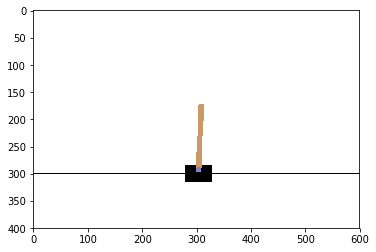

In [2]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")

# gym compatibility: unwrap TimeLimit
if hasattr(env, 'env'):
    env = env.env

env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

### 构建策略网络

策略接受状态，输出动作的分布


In [3]:
state_dim

(4,)

In [3]:
# keras和tensorflow结合方式
import tensorflow as tf
from keras.layers import Input, Dense,InputLayer
import keras

# create input variables. We only need <s,a,R> for REINFORCE
states_ph = tf.placeholder(tf.float32, (None,)+state_dim, name="states")
actions_ph = tf.placeholder(tf.int32, name="action_ids")
cumulative_rewards_ph = tf.placeholder(tf.float32, name="cumulative_returns")

layer1 = Dense(units=256, activation="relu")(states_ph)

layer2 = Dense(units=256, activation="relu")(layer1)

logits = Dense(units=n_actions)(layer2)

policy = tf.nn.softmax(logits)

log_policy = tf.nn.log_softmax(logits)


# utility function to pick action in one given state
def get_action_proba(s, sess):
  actions = sess.run(policy, feed_dict={states_ph:np.array([s])}) 
  return actions[0]


Using TensorFlow backend.


### loss function

#### Loss function and updates

目标函数

$$ J \approx  { 1 \over N } \sum  _{s_i,a_i} \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$


等价于: 

$$ \hat J \approx { 1 \over N } \sum  _{s_i,a_i} log \pi_\theta (a_i | s_i) \cdot G(s_i,a_i) $$




In [4]:
# get probabilities for parti
indices = tf.stack([tf.range(tf.shape(log_policy)[0]), actions_ph], axis=-1)
log_policy_for_actions = tf.gather_nd(log_policy, indices)
print("log_policy_for_actions.shape={0}".format(log_policy_for_actions.shape))

# policy objective as in the last formula. please use mean, not sum.
# note: you need to use log_policy_for_actions to get log probabilities for actions taken.

J = tf.reduce_mean(log_policy_for_actions * cumulative_rewards_ph)

# regularize with entropy
#entropy = <compute entropy. Don't forget the sign!>

# all network weights
#all_weights = 

# weight updates. maximizing J is same as minimizing -J. Adding negative entropy.
#loss = -J - 0.1*entropy
loss = -J

#update = tf.train.AdamOptimizer().minimize(loss, var_list=all_weights)
update = tf.train.AdamOptimizer().minimize(loss)


log_policy_for_actions.shape=(?,)


### 计算累积奖励

In [5]:
def get_cumulative_rewards(rewards,  # rewards at each step
                           gamma=0.99  # discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton '16)
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...

    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute R_t = r_t + gamma*R_{t+1} recurrently

    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """

    #<your code here >
    cumulative_rewards = []
    for r in reversed(rewards):
      if len(cumulative_rewards) == 0:
        cr = r
      else:
        cr = r + gamma * cumulative_rewards[-1]
      cumulative_rewards.append(cr)
    
    return np.array(list(reversed(cumulative_rewards)),dtype=np.float32)
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0, 0, 1, 0, 0, 1, 0], gamma=0.9), [
                   1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, -2, 3, -4, 0], gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards(
    [0, 0, 1, 2, 3, 4, 0], gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")



looks good!


In [0]:
def train_step(_states, _actions, _rewards, sess):
    """given full session, trains agent with policy gradient"""
    _cumulative_rewards = get_cumulative_rewards(_rewards)
    #print("_states={0}".format(_states))
    #print("_states.shape={0}".format(_states.shape))
    #print("_actions.shape={0}".format(_actions.shape))
    #print("_cumulative_rewards.shape={0}".format(_cumulative_rewards.shape))
    _states = np.array(_states,dtype=np.float32)
    _actions = np.array(_actions, dtype=np.int32)
    train_loss,_ = sess.run([loss,update], feed_dict={states_ph: _states, actions_ph: _actions, cumulative_rewards_ph: _cumulative_rewards})
    return train_loss
    

### 玩游戏

In [0]:
def generate_session(sess,t_max=1000):
    """play env with REINFORCE agent and train at the session end"""

    # arrays to record session
    states, actions, rewards = [], [], []


    s = env.reset()

    for t in range(t_max):

        # action probabilities array aka pi(a|s)
        action_probas = get_action_proba(s, sess)
        #print("action_probas={0}".format(action_probas))

        a = np.random.choice(range(n_actions), size=1, p=action_probas)[0]
        

        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break
    #print(states)
    train_loss = train_step(states, actions, rewards, sess)

    return (sum(rewards), train_loss)

def generate_session_data(sess,t_max=1000):
    """play env with REINFORCE agent and train at the session end"""

    # arrays to record session
    states, actions, rewards = [], [], []


    s = env.reset()

    for t in range(t_max):

        # action probabilities array aka pi(a|s)
        action_probas = get_action_proba(s, sess)
        #print("action_probas={0}".format(action_probas))

        a = np.random.choice(range(n_actions), size=1, p=action_probas)[0]
        

        new_s, r, done, info = env.step(a)

        # record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)

        s = new_s
        if done:
            break
    #print(states)
    #train_step(states, actions, rewards, sess)

    return states, actions, rewards

In [0]:
from keras import backend as K
import matplotlib.pyplot as plt
sess = tf.Session()
K.set_session(sess)
sess.run(tf.global_variables_initializer())

### 验证模型正确性

loss是否减少

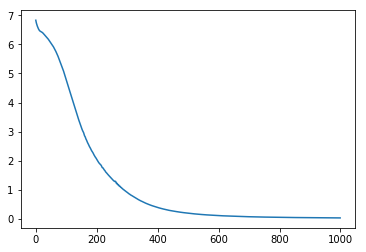

In [18]:
states, actions, rewards = generate_session_data(sess,t_max=1000)
train_loss=[]
for i in range(1000):
  train_loss.append(train_step(states, actions, rewards, sess))
plt.plot(train_loss)

sess.run(tf.global_variables_initializer())

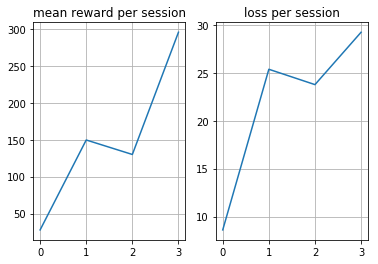

mean reward:295.670
You Win!


In [19]:
from IPython.display import clear_output
total_rewards = []
total_loss = []
for i in range(100):

    rewards_loss = [generate_session(sess) for _ in range(100)]  # generate new sessions
    print("mean reward:%.3f" % (np.mean(rewards)))
    rewards = [i[0] for i in rewards_loss]
    losses = [i[1] for i in rewards_loss]
    average_reward = np.mean(rewards)
    average_loss = np.mean(losses)
    
    total_rewards.append(average_reward)
    total_loss.append(average_loss)
    clear_output(True)
    plt.subplot(1, 2, 1)
    plt.title("mean reward per session")
    plt.plot(total_rewards)
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.title("loss per session")
    plt.plot(total_loss)
    plt.grid()
    plt.show()
    
    if average_reward > 300:
        print("You Win!")
        break


### 展示

In [11]:
# show video
from IPython.display import HTML
import os

video_names = list(
    filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1]))  # this may or may not be _last_ video. Try other indices

FileNotFoundError: ignored